In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [95]:
df = pd.read_csv("books.csv")
genres_df = pd.read_csv('goodreads_data.csv')

df = df.drop(['isbn', 'isbn13', 'image_url', 'small_image_url', 
              'id', 'best_book_id', 'work_id', 'books_count', 'original_title'], axis=1)

df = df[df['original_publication_year'].notnull()]

df = df[df['language_code'].isin(['eng', 'en-US', 'en-GB', 'en-CA'])]

df = df[~df['language_code'].isin(['1', 'rum', 'mul', 'nan', ''])]

df.reset_index(drop=True, inplace=True)

df
genres_df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8711 entries, 0 to 8710
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    8711 non-null   int64  
 1   authors                    8711 non-null   object 
 2   original_publication_year  8711 non-null   float64
 3   title                      8711 non-null   object 
 4   language_code              8711 non-null   object 
 5   average_rating             8711 non-null   float64
 6   ratings_count              8711 non-null   int64  
 7   work_ratings_count         8711 non-null   int64  
 8   work_text_reviews_count    8711 non-null   int64  
 9   ratings_1                  8711 non-null   int64  
 10  ratings_2                  8711 non-null   int64  
 11  ratings_3                  8711 non-null   int64  
 12  ratings_4                  8711 non-null   int64  
 13  ratings_5                  8711 non-null   int64

In [46]:
df.describe()

,book_id,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,8.711000e+03,8711.000000,8711.000000,8.711000e+03,8.711000e+03,8711.000000,8711.000000,8711.000000,8711.000000,8.711000e+03,8.711000e+03
mean,5.538892e+06,1982.371140,4.002980,5.831321e+04,6.435508e+04,3166.272873,1455.407646,3345.179773,12294.123522,2.151758e+04,2.574278e+04
std,7.721274e+06,157.879817,0.252378,1.672886e+05,1.779868e+05,6478.791451,7074.479363,10303.505860,30146.554107,5.440911e+04,8.492611e+04
min,1.000000e+00,-1750.000000,2.470000,2.773000e+03,6.323000e+03,11.000000,11.000000,30.000000,323.000000,8.720000e+02,7.540000e+02
25%,4.548900e+04,1991.000000,3.850000,1.416800e+04,1.611100e+04,768.500000,202.000000,683.000000,3243.000000,5.679500e+03,5.553500e+03
50%,4.335670e+05,2005.000000,4.020000,2.237300e+04,2.512700e+04,1526.000000,415.000000,1224.000000,5172.000000,8.876000e+03,9.287000e+03
75%,9.971048e+06,2011.000000,4.180000,4.432350e+04,4.962800e+04,3036.000000,956.000000,2568.500000,10016.000000,1.732700e+04,1.873050e+04
max,3.328864e+07,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


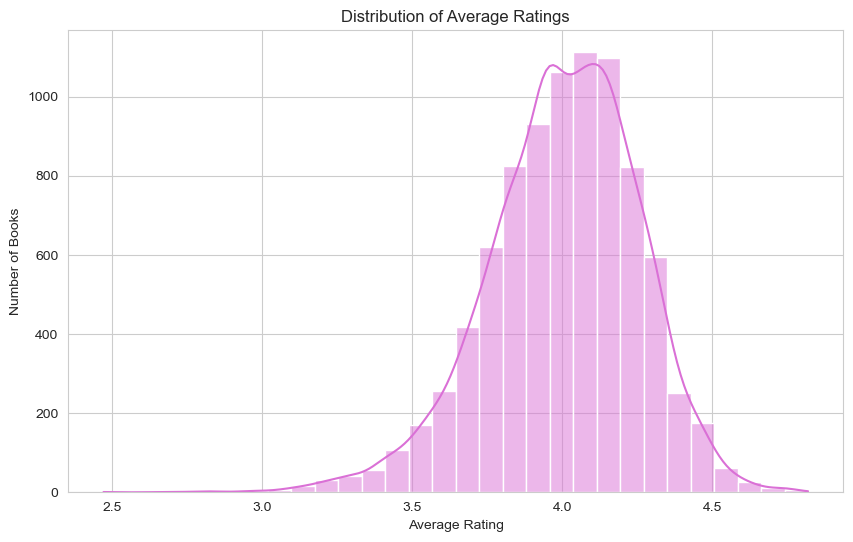

In [47]:
sns.histplot(df['average_rating'], bins=30, kde=True, color='orchid')
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Books")
plt.show()

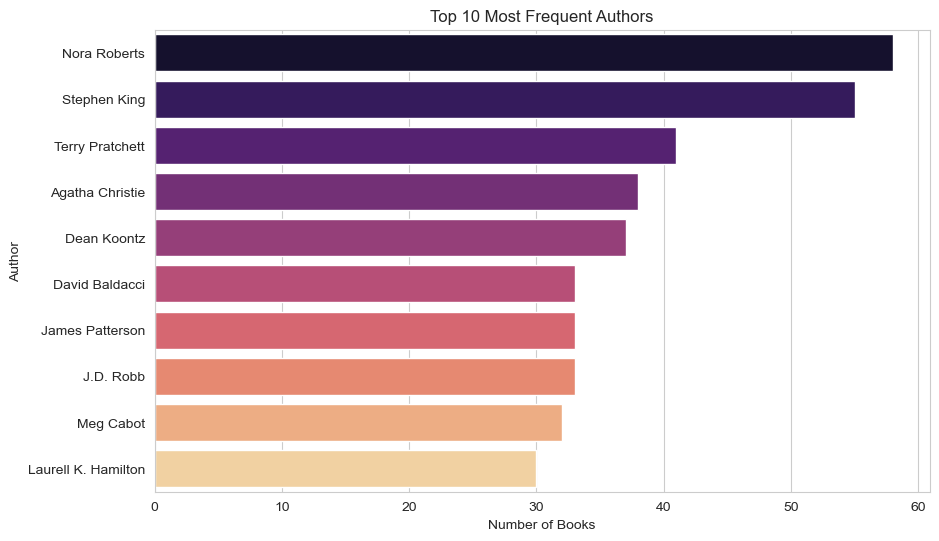

In [48]:
top_authors = df['authors'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index, palette='magma')
plt.title('Top 10 Most Frequent Authors')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

In [49]:
top_books = df.sort_values(by='average_rating', ascending=False)[['title', 'authors', 'average_rating']].head(10)
top_books.reset_index(drop=True, inplace=True)
top_books

,title,authors,average_rating
0,The Complete Calvin and Hobbes,Bill Watterson,4.82
1,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",4.77
2,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77
3,Mark of the Lion Trilogy,Francine Rivers,4.76
4,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76
5,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,4.75
6,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74
7,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,4.74
8,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73
9,The Indispensable Calvin and Hobbes,Bill Watterson,4.73


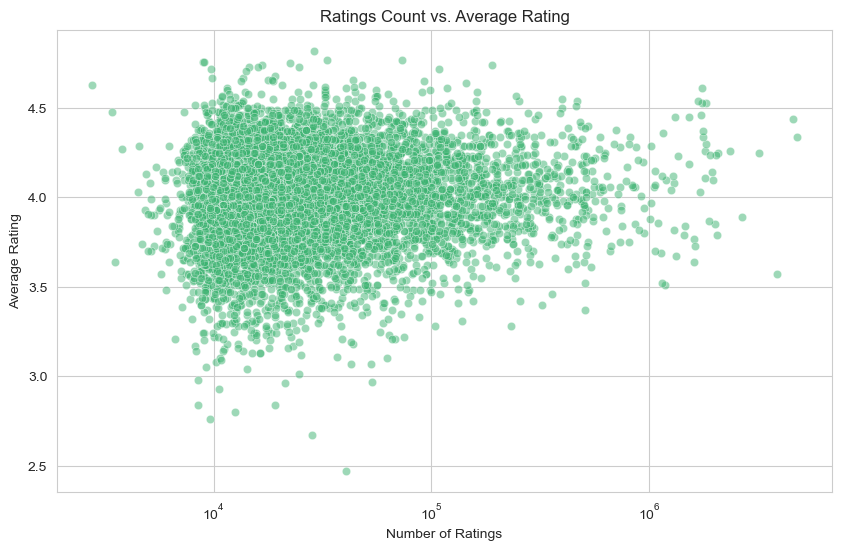

In [50]:
sns.scatterplot(x='ratings_count', y='average_rating', data=df, alpha=0.5, color='mediumseagreen')
plt.title('Ratings Count vs. Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')  
plt.show()

C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


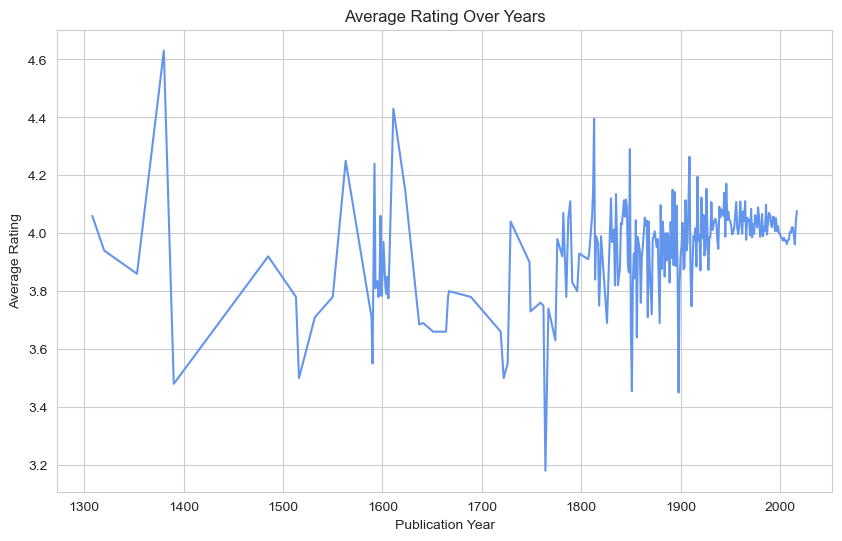

In [51]:
df_filtered = df[(df['original_publication_year'] >= 1000) & (df['original_publication_year'] <= 2025)]
sns.lineplot(data=df_filtered.groupby('original_publication_year')['average_rating'].mean(), color='cornflowerblue')
plt.title('Average Rating Over Years')
plt.xlabel("Publication Year")
plt.ylabel("Average Rating")
plt.show()

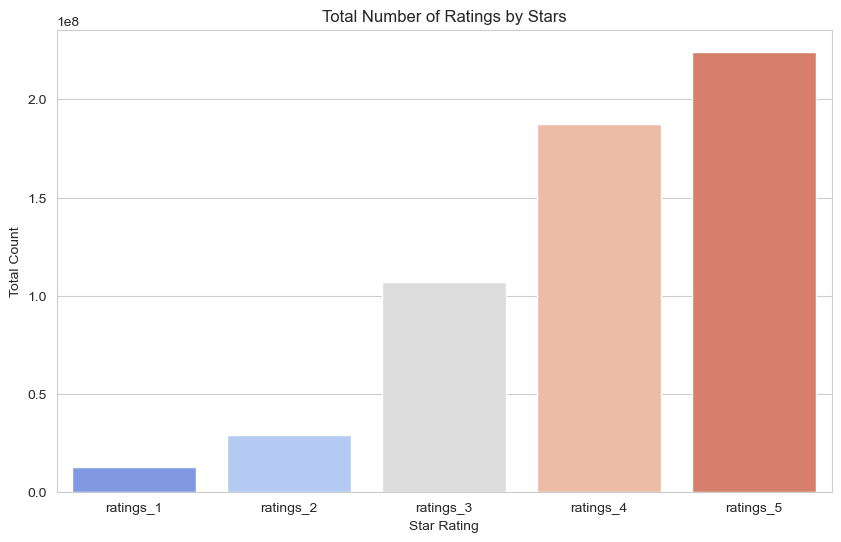

In [52]:
rating_cols = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
total_ratings = df[rating_cols].sum()
sns.barplot(x=total_ratings.index, y=total_ratings.values, palette='coolwarm')
plt.title('Total Number of Ratings by Stars')
plt.xlabel('Star Rating')
plt.ylabel('Total Count')
plt.show()

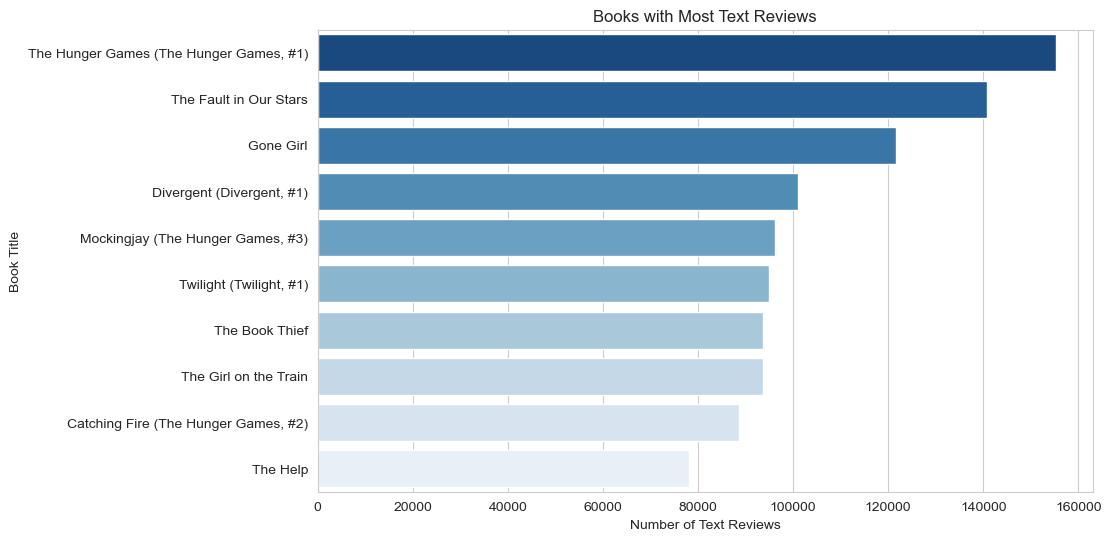

In [53]:
top_reviewed = df.sort_values(by='work_text_reviews_count', ascending=False).head(10)

sns.barplot(x='work_text_reviews_count', y='title', data=top_reviewed, palette='Blues_r')
plt.title('Books with Most Text Reviews')
plt.xlabel('Number of Text Reviews')
plt.ylabel('Book Title')
plt.show()

C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


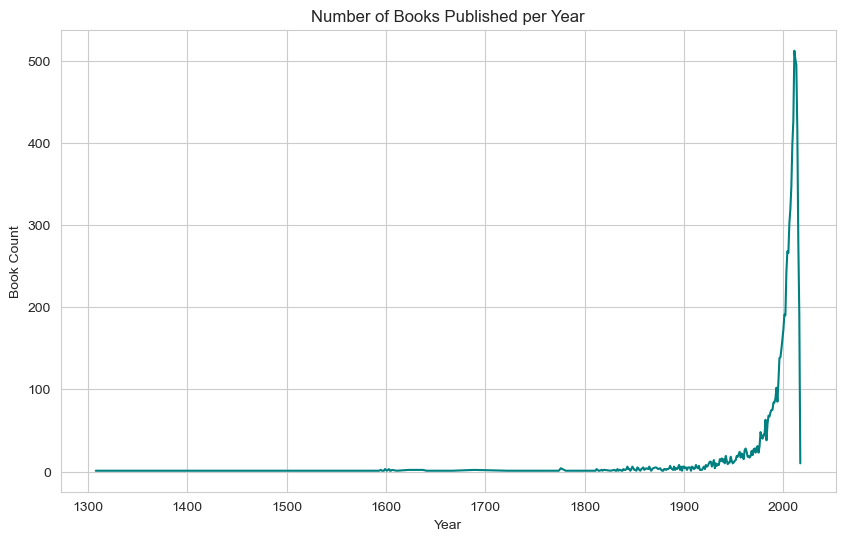

In [54]:
yearly_books = df_filtered['original_publication_year'].value_counts().sort_index()

sns.lineplot(x=yearly_books.index, y=yearly_books.values, color='teal')
plt.title('Number of Books Published per Year')
plt.xlabel('Year')
plt.ylabel('Book Count')
plt.show()

C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


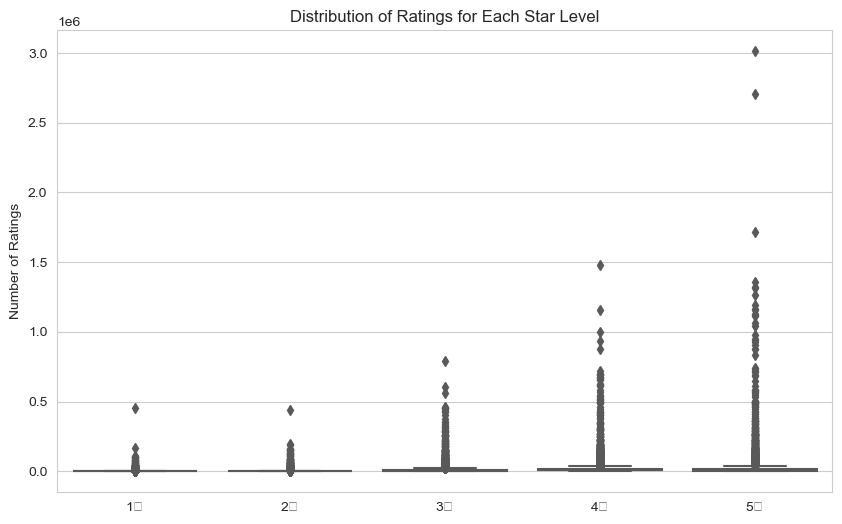

In [55]:
rating_cols = ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
df_ratings = df[rating_cols].copy()
df_ratings.columns = ['1★', '2★', '3★', '4★', '5★']

sns.boxplot(data=df_ratings, palette='Set2')
plt.title('Distribution of Ratings for Each Star Level')
plt.ylabel('Number of Ratings')
plt.show()

In [56]:
corr, p_value = pearsonr(df['ratings_count'], df['average_rating'])
print(f"Correlation: {corr:.3f}")
print(f"P-value: {p_value:.5f}")

Correlation: 0.048
P-value: 0.00001


In [57]:
popular = df[df['ratings_count'] > 100000]['average_rating']
not_popular = df[df['ratings_count'] <= 100000]['average_rating']

t_stat, p_value = ttest_ind(popular, not_popular)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")

T-statistic: 4.068
P-value: 0.00005


In [58]:
def dominant_star(row):
    star_counts = row[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']]
    return star_counts.idxmax()

df['dominant_rating'] = df.apply(dominant_star, axis=1)

In [59]:
groups = []

for star in ['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']:
    group = df[df['dominant_rating'] == star]['average_rating']
    if not group.empty:
        groups.append(group)

f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.5f}")

F-statistic: 3613.182
P-value: 0.00000


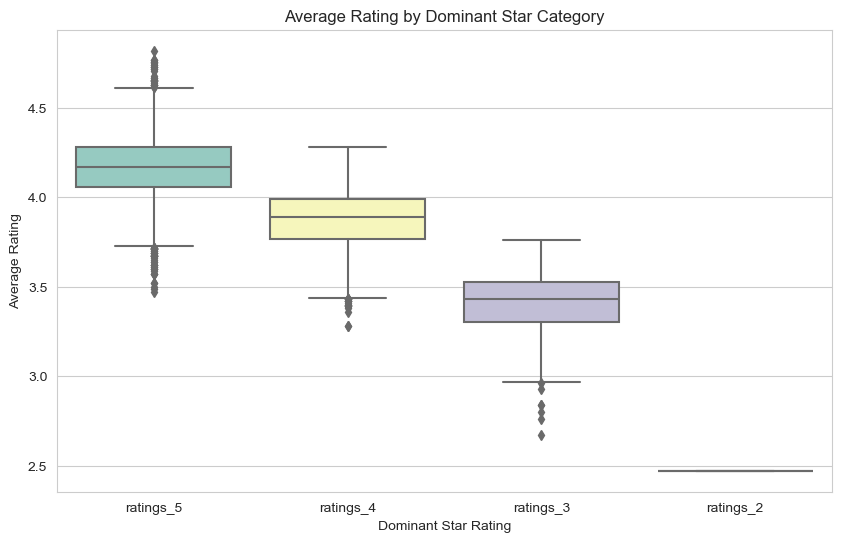

In [60]:
sns.boxplot(x='dominant_rating', y='average_rating', data=df, palette='Set3')
plt.title('Average Rating by Dominant Star Category')
plt.xlabel('Dominant Star Rating')
plt.ylabel('Average Rating')
plt.show()

In [61]:
df['high_rating'] = df['average_rating'].apply(lambda x: 1 if x >= 4.0 else 0)

In [62]:
features = ['ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']
X = df[features]
y = df['high_rating']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[756  19]
 [ 24 944]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       775
           1       0.98      0.98      0.98       968

    accuracy                           0.98      1743
   macro avg       0.97      0.98      0.98      1743
weighted avg       0.98      0.98      0.98      1743



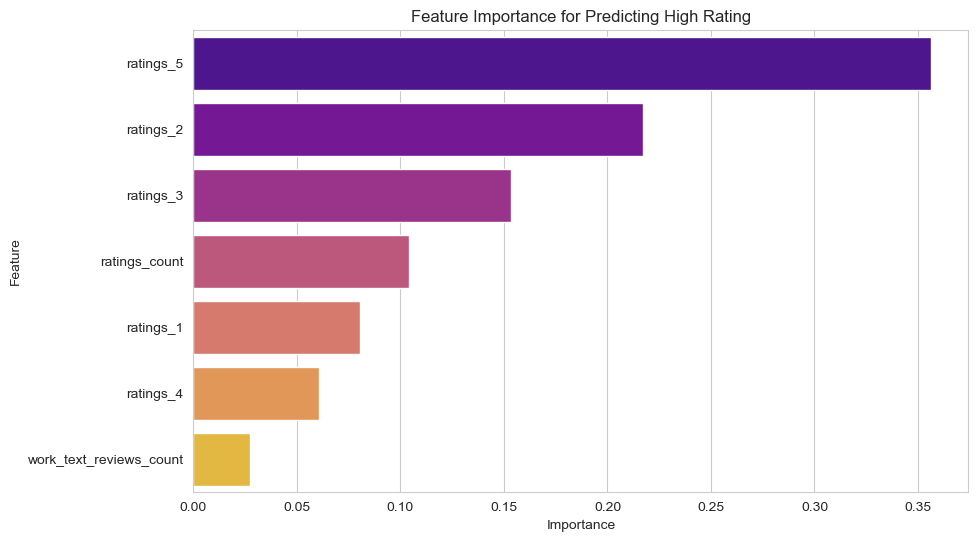

In [65]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='plasma')
plt.title('Feature Importance for Predicting High Rating')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

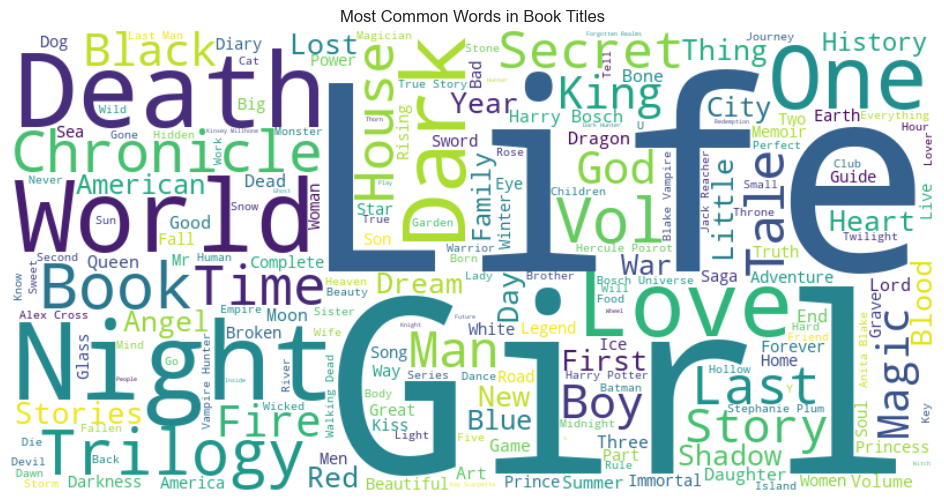

In [66]:
text = ' '.join(df['title'].dropna())
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='viridis').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Book Titles')
plt.show()

C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


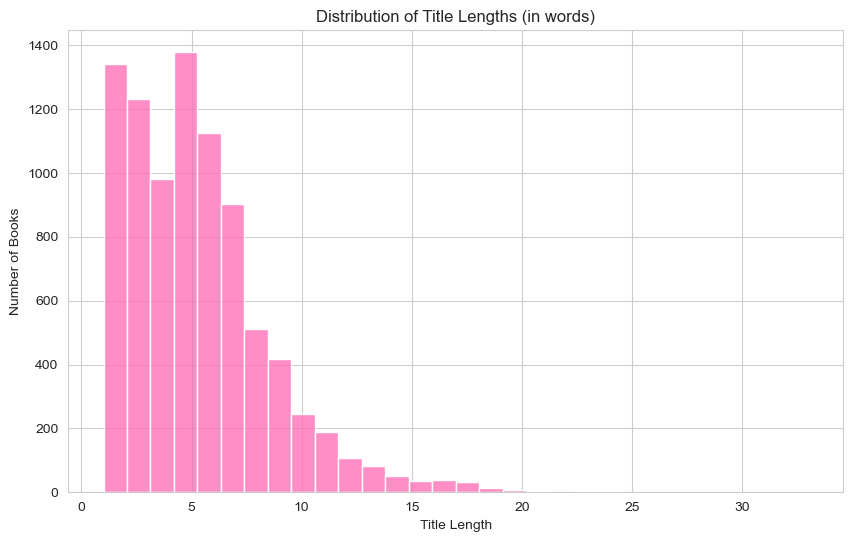

In [67]:
df['title_length'] = df['title'].apply(lambda x: len(x.split()))

sns.histplot(df['title_length'], bins=30, color='hotpink')
plt.title('Distribution of Title Lengths (in words)')
plt.xlabel('Title Length')
plt.ylabel('Number of Books')
plt.show()

C:\Users\sanjl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


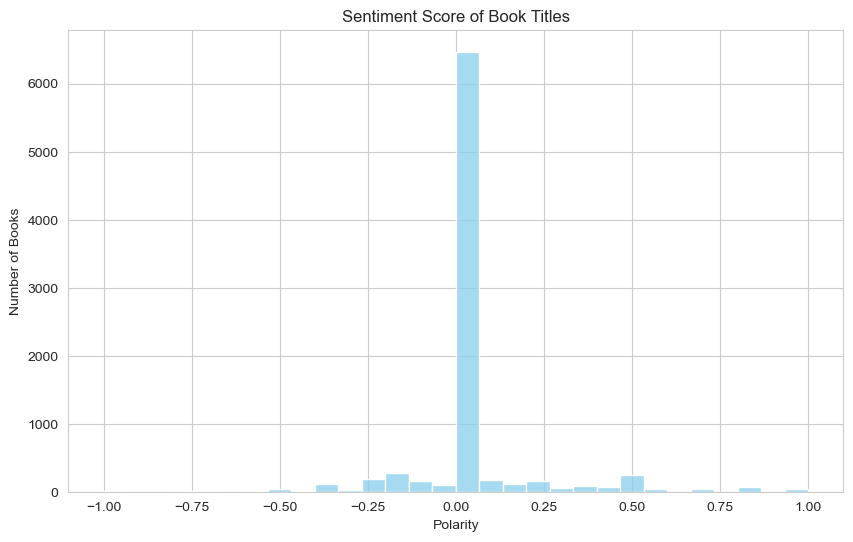

In [68]:
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.histplot(df['title_sentiment'], bins=30, color='skyblue')
plt.title('Sentiment Score of Book Titles')
plt.xlabel('Polarity')
plt.ylabel('Number of Books')
plt.show()

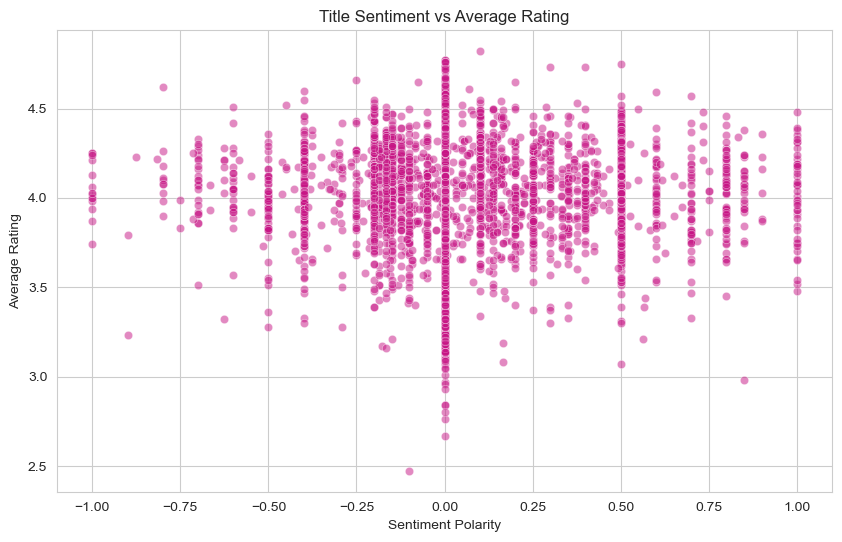

In [69]:
sns.scatterplot(x='title_sentiment', y='average_rating', data=df, alpha=0.5, color='mediumvioletred')
plt.title('Title Sentiment vs Average Rating')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Average Rating')
plt.show()

In [70]:
df['is_murder'] = df['title'].str.contains('murder', case=False, na=False)
df = df[df['is_murder']].head(10)
df.reset_index(drop=True, inplace=True)
df

,book_id,authors,original_publication_year,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,dominant_rating,high_rating,title_length,title_sentiment,is_murder
0,21996,"Erik Larson, Tony Goldwyn",2003.0,"The Devil in the White City: Murder, Magic, an...",eng,3.98,309385,350607,25846,6687,18709,69012,135360,120839,ratings_4,0,16,0.40,True
1,13137,James Patterson,2001.0,"1st to Die (Women's Murder Club, #1)",en-US,4.05,233984,242428,5039,4464,10087,48616,83796,95465,ratings_5,1,7,0.00,True
2,343,"Patrick Süskind, John E. Woods",1985.0,Perfume: The Story of a Murderer,eng,4.00,178135,222754,10057,5659,12862,41804,78658,83771,ratings_5,1,6,0.00,True
3,237209,Tana French,2007.0,"In the Woods (Dublin Murder Squad, #1)",eng,3.74,188024,201721,15392,6553,15636,51430,77182,50920,ratings_4,0,7,0.00,True
4,16304,Agatha Christie,1934.0,"Murder on the Orient Express (Hercule Poirot, ...",eng,4.16,138444,173662,8713,706,4027,30417,70825,67687,ratings_4,1,8,0.00,True
5,105992,"Vincent Bugliosi, Curt Gentry",1974.0,Helter Skelter: The True Story of the Manson M...,en-GB,4.00,92158,94919,2510,1207,4141,21434,35026,33111,ratings_4,1,9,0.35,True
6,16331,Agatha Christie,1930.0,"Murder at the Vicarage (Miss Marple, #1)",eng,4.03,93963,100137,2199,1170,3228,22393,37786,35560,ratings_4,1,7,0.00,True
7,1914973,Tana French,2008.0,"The Likeness (Dublin Murder Squad, #2)",eng,4.05,72480,80243,6945,915,2856,14814,34478,27180,ratings_4,1,6,0.00,True
8,25019,Simon Winchester,1998.0,The Professor and the Madman: A Tale of Murder...,eng,3.84,71411,75908,4547,2012,4388,18659,29538,21311,ratings_4,0,18,0.00,True
9,13136,"James Patterson, Andrew Gross",2002.0,"2nd Chance (Women's Murder Club, #2)",eng,4.01,68834,75300,2128,391,2580,17641,29784,24904,ratings_4,1,6,0.00,True


In [71]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20)
title_vectors = tfidf.fit_transform(df['title'])

tfidf_df = pd.DataFrame(title_vectors.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head()

,10,club,dublin,manson,marple,miss,murder,murderer,murders,orient,oxford,professor,skelter,squad,story,tale,true,vicarage,white,women
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.405732,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.913992,0.000000
1,0.000000,0.663331,0.000000,0.0,0.0,0.0,0.346387,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.663331
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.761905,0.0,0.000000,0.0,0.0,0.0,0.000000,0.647689,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.663331,0.0,0.0,0.0,0.346387,0.000000,0.0,0.000000,0.0,0.0,0.0,0.663331,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.674651,0.000000,0.000000,0.0,0.0,0.0,0.299486,0.000000,0.0,0.674651,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [72]:
X_titles = df['title']
y = df['high_rating']

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),
    ('model', LogisticRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X_titles, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

print(pipe.score(X_test, y_test))

0.5


In [73]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['title'])

In [96]:
df['title_clean'] = df['title'].str.lower().str.strip()
genres_df['title_clean'] = genres_df['Book'].str.lower().str.strip()

In [97]:
genres_df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,title_clean
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...,to kill a mockingbird
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...,harry potter and the philosopher’s stone (harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...,pride and prejudice
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...,the diary of a young girl
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...,animal farm


In [99]:
merged = df.merge(genres_df[['title_clean', 'Genres']], on='title_clean', how='left')

In [100]:
merged[['title', 'Genres']].sample(10)

,title,Genres
3487,The Other Queen (The Plantagenet and Tudor Nov...,NaN
5700,A Rogue by Any Other Name (The Rules of Scound...,NaN
4659,"Bite Club (The Morganville Vampires, #10)",NaN
671,"The Passage (The Passage, #1)","['Horror', 'Fiction', 'Science Fiction', 'Fant..."
8333,Johnny Mnemonic,NaN
3922,A Single Shard,"['Historical Fiction', 'Young Adult', 'Fiction..."
8359,"Ultimate Spider-Man, Volume 1: Power and Respo...",NaN
4183,Five Quarters of the Orange,"['Fiction', 'Historical Fiction', 'France', 'H..."
7448,"The Darkest Hour (KGI, #1)",NaN
3670,Songs of Innocence and of Experience,"['Poetry', 'Classics', 'Fiction', '18th Centur..."


In [101]:
merged['Genres'].notnull().mean()

0.39444949954504094

In [103]:
genre_df = merged[merged['Genres'].notnull()].copy()

In [104]:
genre_encoded = pd.get_dummies(genre_df['Genres'])

In [105]:
features = pd.concat([
    genre_df[['average_rating', 'ratings_count', 'work_text_reviews_count']].fillna(0),
    genre_encoded
], axis=1)

In [113]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
genre_df['cluster'] = kmeans.fit_predict(features_scaled)

C:\Users\sanjl\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


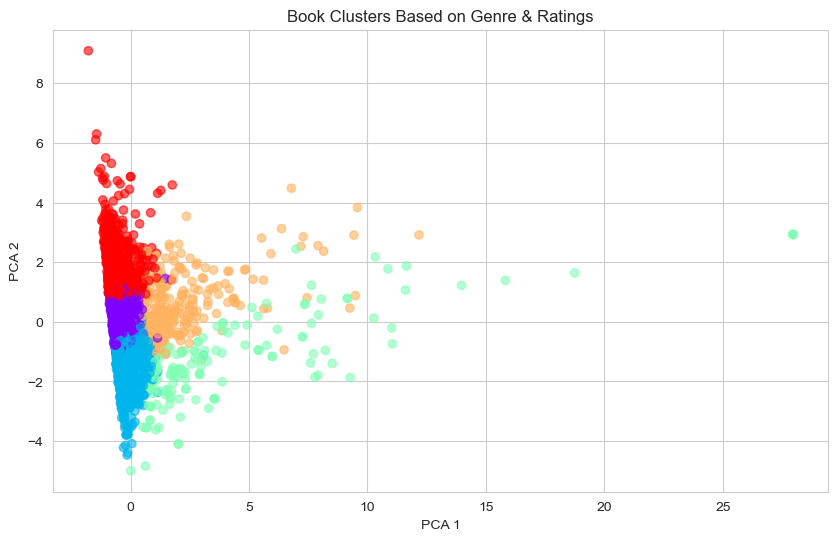

In [114]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(features_scaled)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=genre_df['cluster'], cmap='rainbow', alpha=0.6)
plt.title('Book Clusters Based on Genre & Ratings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [115]:
for i in range(5):
    print(f"\nCluster {i}:")
    print(genre_df[genre_df['cluster'] == i][['title', 'Genres', 'average_rating']].sample(3, random_state=42))


Cluster 0:
                                                  title  \
4217  Eat and Run: My Unlikely Journey to Ultramarat...   
871         Dead in the Family (Sookie Stackhouse, #10)   
2291                     Roses are Red (Alex Cross, #6)   

                                                 Genres  average_rating  
4217  ['Nonfiction', 'Sports', 'Health', 'Memoir', '...            3.95  
871   ['Fantasy', 'Vampires', 'Paranormal', 'Urban F...            3.88  
2291  ['Mystery', 'Fiction', 'Thriller', 'Crime', 'S...            4.02  

Cluster 1:
                                       title  \
1828                                  Stoner   
1005  The Power of Six (Lorien Legacies, #2)   
2955                               Ficciones   

                                                 Genres  average_rating  
1828  ['Fiction', 'Classics', 'Literature', 'Novels'...            4.28  
1005  ['Young Adult', 'Fantasy', 'Science Fiction', ...            4.17  
2955  ['Fiction', 'Short Sto

In [122]:
cluster_summary = genre_df.groupby('cluster').agg({
    'average_rating': 'mean',
    'ratings_count': 'mean',
    'work_text_reviews_count': 'mean',
    'Genres': lambda x: x.mode()[0] if len(x.mode()) > 0 else "none"
}).reset_index()

cluster_summary.columns = ['Cluster', 'Avg Rating', 'Avg Ratings Count', 'Avg Reviews Count', 'Top Genre']
cluster_summary

,Cluster,Avg Rating,Avg Ratings Count,Avg Reviews Count,Top Genre
0,0,3.984011,47164.147479,2720.064710,"['Fiction', 'Young Adult', 'Childrens', 'Middl..."
1,1,4.249189,49735.186424,2983.328267,"['Thriller', 'Fiction', 'Mystery', 'Crime', 'A..."
2,2,4.343724,655499.848276,34743.241379,"['Fantasy', 'Young Adult', 'Mythology', 'Ficti..."
3,3,3.973857,415863.170648,17110.529010,"['Young Adult', 'Fantasy', 'Angels', 'Romance'..."
4,4,3.687409,53399.375350,3680.309524,"['Fiction', 'Thriller', 'Mystery', 'Legal Thri..."


In [123]:
cluster_names = {
    0: '🔥 Popular Fantasy',
    1: '💔 Low Rated Romance',
    2: '🔍 Mystery Gems',
    3: '📖 Classic Fiction',
    4: '🎯 Reader Favorites'
}

genre_df['cluster_name'] = genre_df['cluster'].map(cluster_names)

C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sanjl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


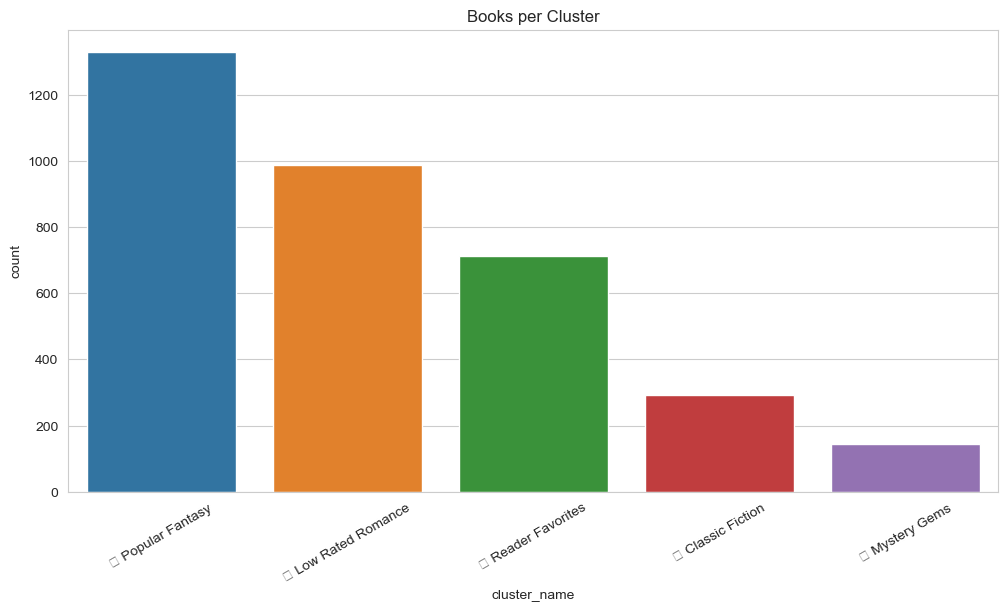

In [124]:
plt.figure(figsize=(12, 6))
sns.countplot(data=genre_df, x='cluster_name', order=genre_df['cluster_name'].value_counts().index)
plt.title('Books per Cluster')
plt.xticks(rotation=30)
plt.show()

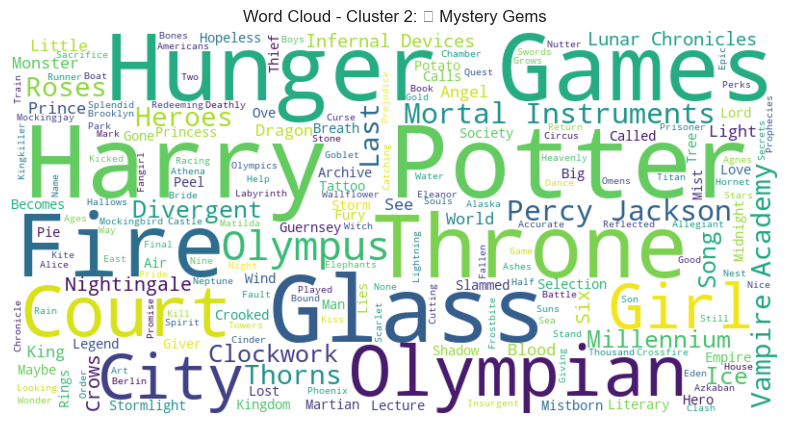

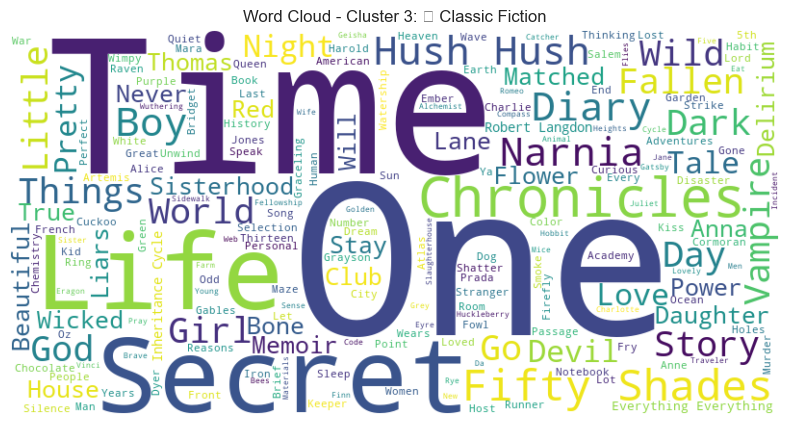

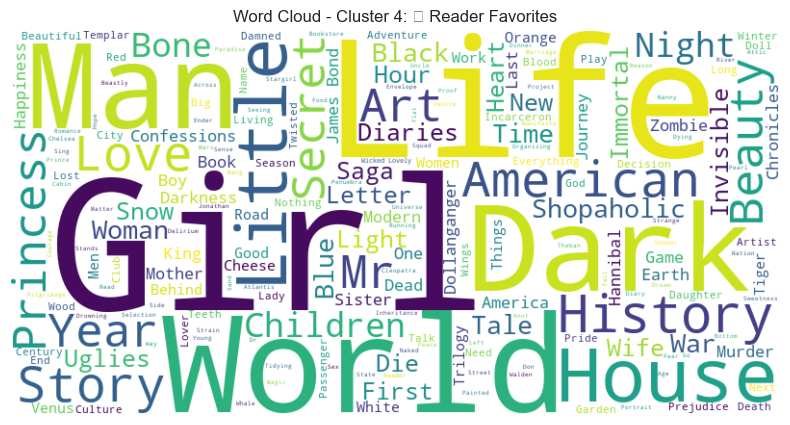

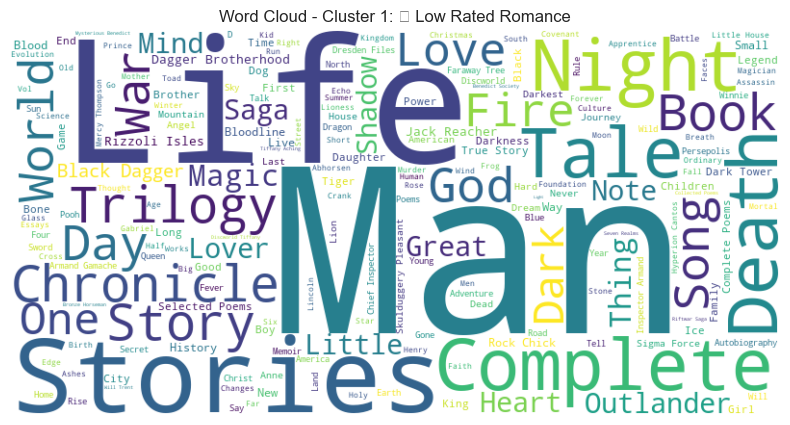

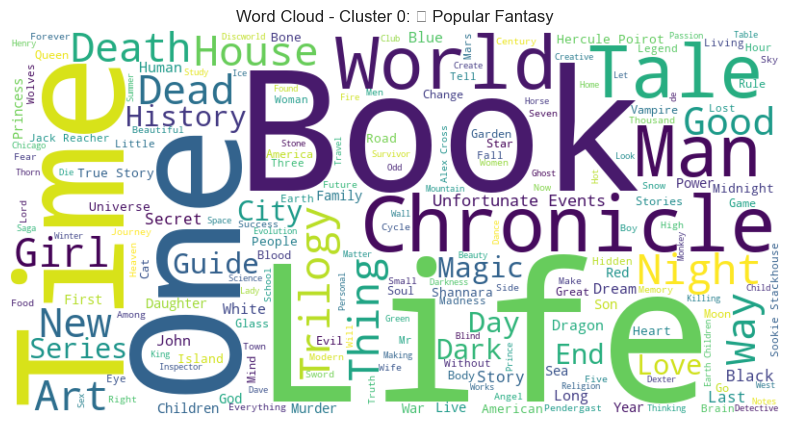

In [125]:
for c in genre_df['cluster'].unique():
    titles = genre_df[genre_df['cluster'] == c]['title'].str.cat(sep=' ')
    wc = WordCloud(width=800, height=400, background_color='white').generate(titles)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - Cluster {c}: {cluster_names[c]}')
    plt.show()

In [126]:
def recommend_books(book_title, df, n=5):
    book_title = book_title.lower().strip()
    if book_title not in df['title_clean'].values:
        return "Sorry, book not found in dataset."

    # Find cluster of the selected book
    book_cluster = df[df['title_clean'] == book_title]['cluster'].values[0]
    
    # Filter books in same cluster
    similar_books = df[(df['cluster'] == book_cluster) & 
                       (df['title_clean'] != book_title)][['title', 'authors', 'average_rating']]
    
    return similar_books.sample(n=n).sort_values(by='average_rating', ascending=False)

In [130]:
genre_df[['title', 'title_clean']].sample(10)

,title,title_clean
3702,"Angels Flight (Harry Bosch, #6; Harry Bosch Un...","angels flight (harry bosch, #6; harry bosch un..."
8160,"Ghost Wars: The Secret History of the CIA, Afg...","ghost wars: the secret history of the cia, afg..."
2569,"The Midwife: A Memoir of Birth, Joy, and Hard ...","the midwife: a memoir of birth, joy, and hard ..."
2305,"The Last Kingdom (The Saxon Stories, #1)","the last kingdom (the saxon stories, #1)"
1860,"Dance Dance Dance (The Rat, #4)","dance dance dance (the rat, #4)"
3031,The World Without Us,the world without us
3418,Garlic and Sapphires: The Secret Life of a Cri...,garlic and sapphires: the secret life of a cri...
829,A Room with a View,a room with a view
4901,The First American: The Life and Times of Benj...,the first american: the life and times of benj...
5004,Notes of a Dirty Old Man,notes of a dirty old man


In [132]:
recommend_books("the silent wife", genre_df)

,title,authors,average_rating
3399,The Adoration of Jenna Fox (Jenna Fox Chronicl...,Mary E. Pearson,3.70
5821,The Winter's Tale,William Shakespeare,3.69
1299,The Story of Edgar Sawtelle,David Wroblewski,3.60
1377,"Extras (Uglies, #4)",Scott Westerfeld,3.59
7996,Anil's Ghost,Michael Ondaatje,3.54
